# Midter Project: Bengali.Al Handwritten Graphemes 

## Team: Zzz...
## Members: Cheng Zeng, Zhi Wang, Zhe Huang

--------------------------------------------------------------------------------------------------------------

In [83]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

## Introduction

This midterm project aims to develop a CNN model to classify the three constituent components of Bengali handwritten characters, including grapheme root, vowel diacritics, and consonant diacritics. Identifying characters by optical recognition is challenging since each Bengali has 11 vowels and 38 consonants in its alphabet, and there are 10 potential diacritics. As a result, a large amount of graphemes (the smallest units in a written language) exist. This quickly adds up to more than 10,000 different grapheme variations. This is a Kaggle competition, of which more information can be found in their website ([Kaggle link](https://www.kaggle.com/c/bengaliai-cv19)). This work by Team **Zzz..** now lives on [github](https://github.com/cengc13/Bengali_Kaggle). 

## Dataset

We start by inspecting the structure of the data folder. Note that the `*.ttf` file is downloaded from the link [notebook by Kaushal Shah](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn). 

In [1]:
for dirname, _, filenames in os.walk('../../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../data/train_image_data_0.parquet
../../data/class_map.csv
../../data/train.csv
../../data/test_image_data_0.parquet
../../data/sample_submission.csv
../../data/test_image_data_3.parquet
../../data/test_image_data_1.parquet
../../data/test_image_data_2.parquet
../../data/bengaliai-cv19.zip
../../data/test.csv
../../data/Kalpurush_Fonts/kalpurush-2.ttf


## Exploratory Data Analysis (EDA)

We look at the **.csv* files 

In [7]:
### training dataframe
DATA_FOLDER = '../../data'
train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
print(train_df.shape)

(200840, 5)


Note that the input is the handwritten image (the last column), while the output should be the classes for the corresponding three constituent components. In the *train.csv* file, there are 200,840 training images. 

In [8]:
### Testing dataframe
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
test_df.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [6]:
test_df.shape

(36, 3)

The testing images consist of 12 images whose constitutent components are listed as independent rows.

In [9]:
### Classes for three components
class_map_df = pd.read_csv(os.path.join(DATA_FOLDER, 'class_map.csv'))
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [11]:
class_map_df.shape

(186, 3)

In [10]:
### Example of submission format
sample_submission_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
sample_submission_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


The submission format is smilar to the testing dataset.

Followed we will discuss the dataformat of the parquet files. We only deal with one of the training and testing parquet file.

In [24]:
train_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'train_image_data_0.parquet'))

In [26]:
print(train_0_df.shape)
train_0_df.head()

(50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


Each train_image_data_x (x = 0...3) contains 50210 rows and 32333 columns - size of each image being: (137, 236). Totally there are 50210 x 4 = 200840 rows in the training set, in consistent the number of images in the train.csv file. Each feature corresponds to a pixel of the image. The values are in the range of $[0,255]$.

In [19]:
test_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'test_image_data_0.parquet'))
test_0_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Test_0,247,253,253,252,252,252,252,253,253,...,254,254,254,254,254,254,253,253,252,250
1,Test_1,253,253,253,253,253,253,253,253,253,...,255,255,255,255,255,255,255,255,255,255
2,Test_2,253,253,253,253,253,252,251,252,252,...,255,255,255,255,255,255,255,254,253,252


In [15]:
test_0_df.shape

(3, 32333)

In total, there are 12 testing images.

### Number of Unique values 

In [27]:
print(f"Train: unique grapheme roots: {train_df.grapheme_root.nunique()}")
print(f"Train: unique vowel diacritics: {train_df.vowel_diacritic.nunique()}")
print(f"Train: unique consonant diacritics: {train_df.consonant_diacritic.nunique()}")
print(f"Train: total unique elements: {train_df.grapheme_root.nunique() + train_df.vowel_diacritic.nunique() + train_df.consonant_diacritic.nunique()}")
print(f"Class map: unique elements: \n{class_map_df.component_type.value_counts()}")
print(f"Total combinations: {pd.DataFrame(train_df.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])).shape[0]}")

Train: unique grapheme roots: 168
Train: unique vowel diacritics: 11
Train: unique consonant diacritics: 7
Train: total unique elements: 186
Class map: unique elements: 
grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64
Total combinations: 1292


### Data distribution 

In [41]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype(os.path.join(DATA_FOLDER, 'Kalpurush_Fonts/kalpurush-2.ttf'), 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

####  Top 10 Grapheme roots in training set

In [42]:
top_10_roots = get_n(train_df, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


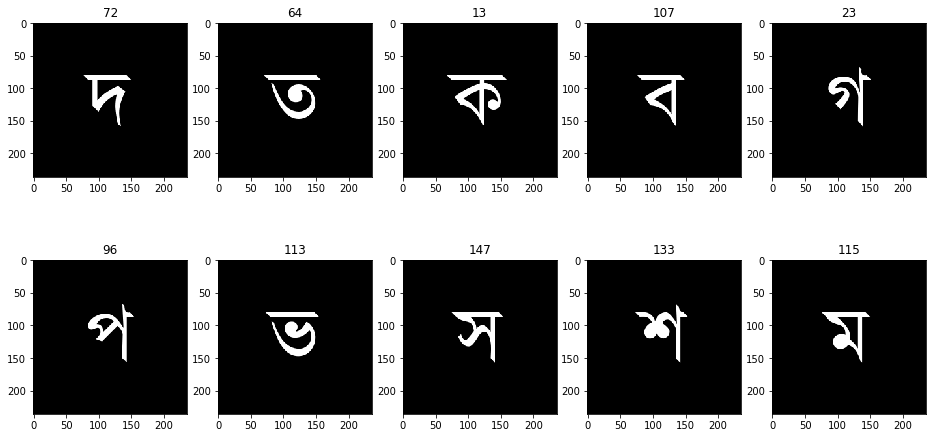

In [45]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')
    ax[i].set_title(top_10_roots['index'].iloc[i])

####  Least 10 Grapheme Roots in training set

In [47]:
bottom_10_roots = get_n(train_df, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


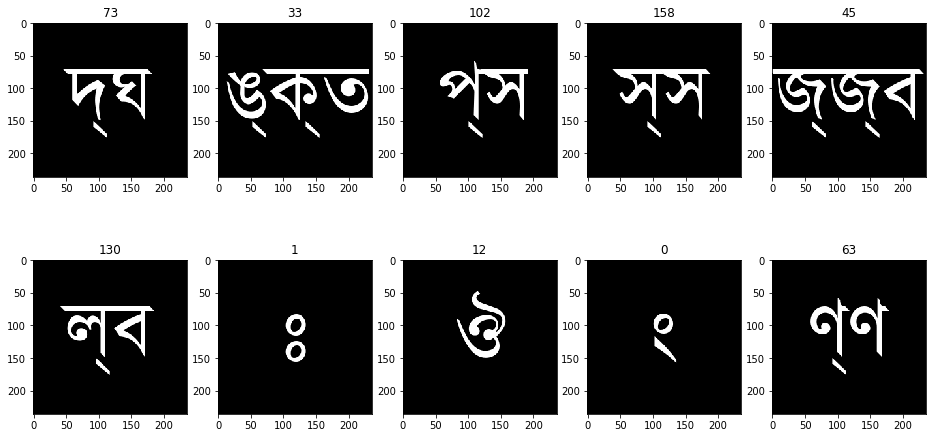

In [48]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')
    ax[i].set_title(bottom_10_roots['index'].iloc[i])

####  Top 5 Vowel Diacritic in training set

In [50]:
top_5_vowels = get_n(train_df, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


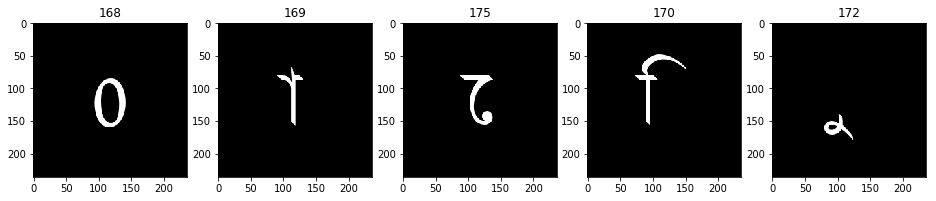

In [51]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')
    ax[i].set_title(top_5_vowels['index'].iloc[i])

#### Top 5 Consonant Diacritic in training data

In [52]:
top_5_consonants = get_n(train_df, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


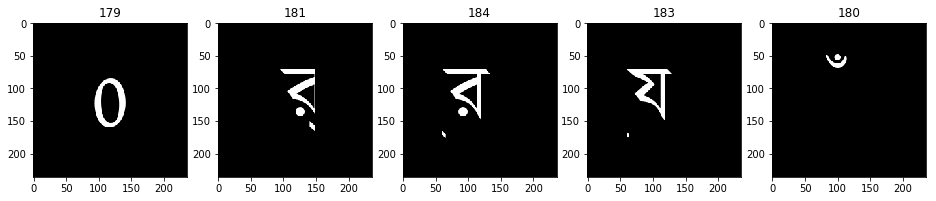

In [53]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')
    ax[i].set_title(top_5_consonants['index'].iloc[i])

#### Data distribution using bar plots

In [55]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes of selected feature; feature is a categorical value
    param: feature - the feature for which we present the distribution of classes
    param: title - title to show in the plot
    param: df - dataframe 
    param: size - size (from 1 to n), multiplied with 4 - size of plot
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show() 

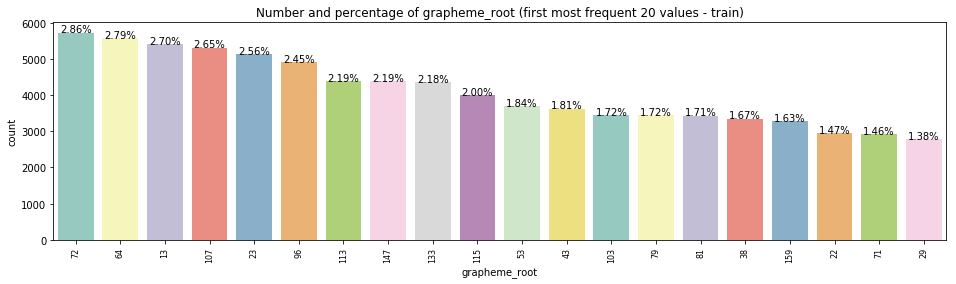

In [56]:
plot_count('grapheme_root', 'grapheme_root (first most frequent 20 values - train)', train_df, size=4)

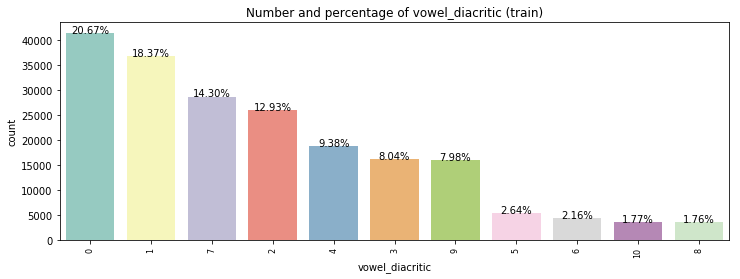

In [57]:
plot_count('vowel_diacritic', 'vowel_diacritic (train)', train_df, size=3)

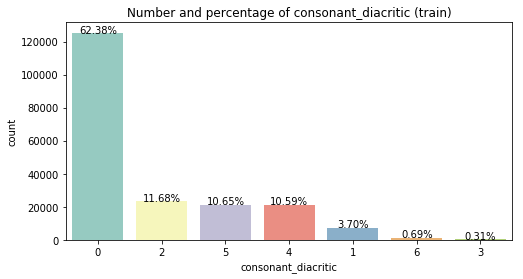

In [59]:
plot_count('consonant_diacritic', 'consonant_diacritic (train)', train_df, size=2)

According to the bar plots, the grapheme roots are more evenly distributed than both vowel diacritics and consonant diascritcs. Vowel diacritics tend to concentrate on class 0, 1, 7 and 2, whereas most of cosonant diacritics (more than 60\%) fall into class 0. 

###  Inspecting the handwritten images

####  25 randomly sampled images

In [87]:
def display_image_from_data(data_df, size=5):
    '''
    Display grapheme images from sample data
    param: data_df - sample of data
    param: size - sqrt(sample size of data)
    '''
    plt.figure()
    fig, ax = plt.subplots(size,size,figsize=(12,12))
    # we show grapheme images for a selection of size x size samples
    for i, index in enumerate(data_df.index):
        image_id = data_df.iloc[i]['image_id']
        flattened_image = data_df.iloc[i].drop('image_id').values.astype(np.uint8)
        unpacked_image = Image.fromarray(flattened_image.reshape(137, 236))

        ax[i//size, i%size].imshow(unpacked_image)
        ax[i//size, i%size].set_title(image_id)
        ax[i//size, i%size].axis('on')

<Figure size 432x288 with 0 Axes>

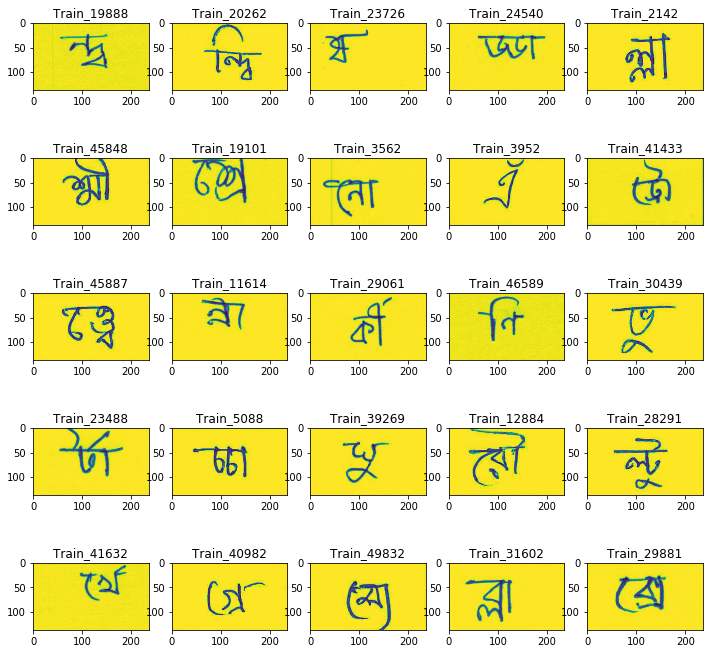

In [88]:
display_image_from_data(train_0_df.sample(25));

####  Sample the same Grapheme with different writings

In [85]:
def display_writting_variety(data_df=train_0_df, grapheme_root=72, vowel_diacritic=0,\
                             consonant_diacritic=0, size=5):
    '''
    This function get a set of grapheme root, vowel diacritic and consonant diacritic
    and display a sample of 25 images for this grapheme
    param: data_df - the dataset used as source of data
    param: grapheme_root - the grapheme root label
    param: vowel_diacritic - the vowel diacritic label
    param: consonant_diacritic - the consonant diacritic label 
    param: size - sqrt(number of images to show)
    '''
    sample_train_df = train_df.loc[(train_df.grapheme_root == grapheme_root) & \
                                  (train_df.vowel_diacritic == vowel_diacritic) & \
                                  (train_df.consonant_diacritic == consonant_diacritic)]
    print(f"total: {sample_train_df.shape}")
    sample_df = data_df.merge(sample_train_df.image_id, how='inner')
    print(f"total: {sample_df.shape}")
    gr = sample_train_df.iloc[0]['grapheme']
    cm_gr = class_map_df.loc[(class_map_df.component_type=='grapheme_root')& \
                             (class_map_df.label==grapheme_root), 'component'].values[0]
    cm_vd = class_map_df.loc[(class_map_df.component_type=='vowel_diacritic')& \
                             (class_map_df.label==vowel_diacritic), 'component'].values[0]    
    cm_cd = class_map_df.loc[(class_map_df.component_type=='consonant_diacritic')& \
                             (class_map_df.label==consonant_diacritic), 'component'].values[0]    
    
    print(f"grapheme: {gr}, grapheme root: {cm_gr}, vowel discritic: {cm_vd}, consonant diacritic: {cm_cd}")
    sample_df = sample_df.sample(size * size)
    display_image_from_data(sample_df, size=size)

total: (163, 5)
total: (36, 32333)
grapheme: দাঁ, grapheme root: দ, vowel discritic: া, consonant diacritic: ঁ


<Figure size 432x288 with 0 Axes>

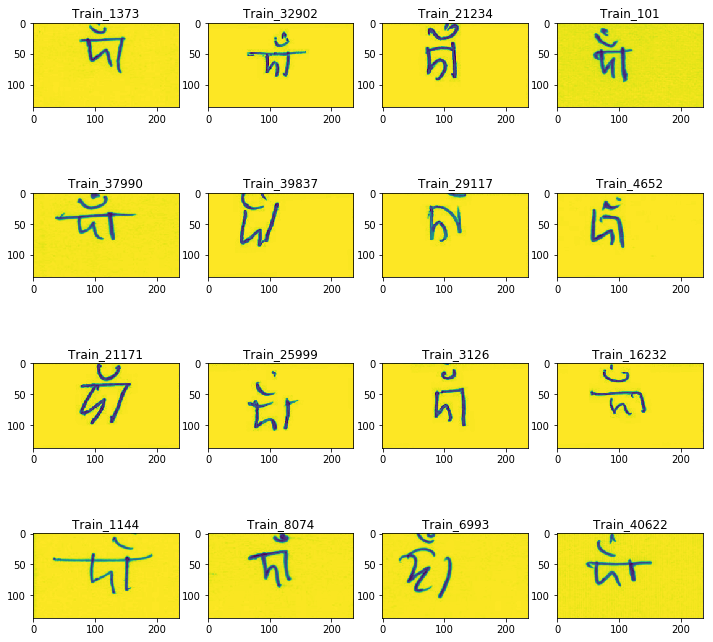

In [89]:
display_writting_variety(train_0_df,72,1,1,4)

## Basic Model  (from the kernel [Kaushal Shah](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn))

### Baseline accuracy 

The baseline accuracy of three components are $1/unque\_values$. So the baseline accuracies for Grapheme roots, vowel diacritic and consonant diascritic are $1/168$, $1/11$, $1/7$, respectively.

### Baseline model identification

> Let's apply some image processing (credits: [this kernel](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn)) while resizing the images, which will center crop the region of interest from the original images.

In [67]:
IMG_SIZE=64
N_CHANNELS=1

In [69]:
from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [84]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [72]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [73]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)
1
model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [74]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [75]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

![model summary](model.png)

In [76]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [78]:
batch_size = 256
epochs = 30

In [79]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [80]:
HEIGHT = 137
WIDTH = 236

### Training loop 

**Do not execute the subsequent code block locally since it is memory demanding.** Next we will dicusss the results for training and validation using only one parquet file "training_image_data_0.parquet". The ratio for training and validation is $92:8$. The training is carried out on Kaggle.

In [1]:
histories = []
# for i in range(1):
#     train_df = pd.merge(pd.read_parquet(f'../../data/train_image_data_{i}.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)
    
#     X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
#     X_train = resize(X_train)/255
    
#     # CNN takes images in shape `(batch_size,
#     h, w, channels)`, so reshape the images
#     X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
#     Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
#     Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

#     print(f'Training images: {X_train.shape}')
#     print(f'Training labels root: {Y_train_root.shape}')
#     print(f'Training labels vowel: {Y_train_vowel.shape}')
#     print(f'Training labels consonants: {Y_train_consonant.shape}')

#     # Divide the data into training and validation set
#     x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, \
#     y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, \
#                                         test_size=0.08, random_state=666)
#     del train_df
#     del X_train
#     del Y_train_root, Y_train_vowel, Y_train_consonant

#     # Data augmentation for creating more training data
#     datagen = MultiOutputDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.15, # Randomly zoom image 
#         width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


#     # This will just calculate parameters required to augment the given data. This won't perform any augmentations
#     datagen.fit(x_train)

#     Fit the model
#     history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
#                               steps_per_epoch=x_train.shape[0] // batch_size, 
#                               callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

#     histories.append(history)
    
#     # Delete to reduce memory usage
#     del x_train
#     del x_test
#     del y_train_root
#     del y_test_root
#     del y_train_vowel
#     del y_test_vowel
#     del y_train_consonant
#     del y_test_consonant
#     gc.collect()

### Analysis of baseline model results 

![training log](training_log.png)

Eventually the validation accuracy for three contituents Grapheme roots, vowel diacritic and consonant diacritic are 0.9505, 0.9851 and 0.9851, respectively. 

### Plots and discussion of model training history

![training loss](training_loss.png) 
![training accuracy](training_acc.png) 

- We can see that both the training and validation accuracy increase with the epochs, indicating that there is little overfitting for the CNN model selected.
- Also, we find that the accuray of all training and validation processes reach plateaus after 30 epochs. It suggests that we use the `EarlyStopping` to save some computational time. 

## Next steps 

The basic model can probably be improved in many ways.

- Enhanced data preprocessing, for example, increasing the sharpness of the boudary of the image.
- Ensemble models, using multiple neural network models with different topology or use `dropout` to create more submodels.
- Data augmentation, it can add more variety into the training set.
- Hyperparameter tuning, such as the number of convolutional layers, number of nodes in each hidden layer, type of activation function and learning rate schedulers.

## Links for the team's baseline Kaggle entry [Zzz...](https://www.kaggle.com/cengc13/basic-model)

## References 

- Most of the codes in this notbook are copied from two kernels by [Kaushal Shah](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn) and [Gabriel Preda](https://www.kaggle.com/gpreda/bengali-ai-handwritten-grapheme-getting-started)